In [117]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf


# from tqdm import tqdm
from tqdm.notebook import tqdm


import time


In [21]:
rolling_window = 5

                            OLS Regression Results                            
Dep. Variable:                  log_y   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                 1.116e+05
Date:                Wed, 19 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:42:19   Log-Likelihood:            -3.5959e+05
No. Observations:              200288   AIC:                         7.192e+05
Df Residuals:                  200286   BIC:                         7.192e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.4566      0.007  -2155.921      0.0

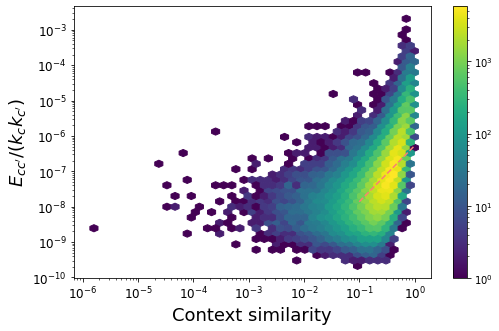

                            OLS Regression Results                            
Dep. Variable:                  log_y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                 2.135e+05
Date:                Wed, 19 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:42:20   Log-Likelihood:            -3.3128e+05
No. Observations:              200288   AIC:                         6.626e+05
Df Residuals:                  200286   BIC:                         6.626e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.0098      0.006  -3023.579      0.0

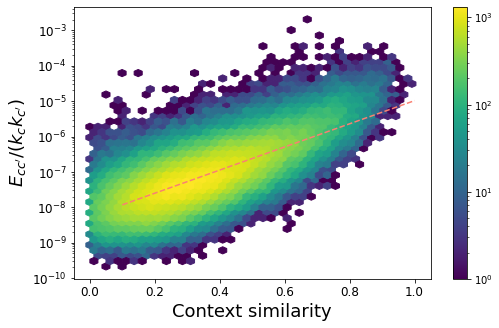

,w1,w2,similarity,similarity_std,year,pair_count,k1,k2,family_count,popularity,popularity_sd,z_score,regression_pow,regression_exp
0,A01B,A01C,0.817786,0.021898,1996,193,6062,6614,2629383,15.248470,3.895517,45.629766,0.004857,0.033189
1,A01B,A01D,0.817335,0.022531,1996,117,6062,6712,2629383,15.474407,3.924198,25.871682,0.004890,0.033333
2,A01B,A01F,0.512621,0.031572,1996,4,6062,3419,2629383,7.882449,2.802508,-1.385348,0.001735,0.002495
3,A01B,A01G,0.608446,0.047579,1996,50,6062,12257,2629383,28.258315,5.297335,4.104269,0.004397,0.009919
4,A01B,A01H,0.527471,0.034622,1996,0,6062,4823,2629383,11.119349,3.327667,-3.341485,0.002084,0.003203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008375,H05F,H05H,0.390195,0.056334,2000,0,876,4321,3089246,1.225282,1.105993,-1.107856,0.000618,0.000544
1008376,H05F,H05K,0.478308,0.060720,2000,24,876,53626,3089246,15.206421,3.865000,2.275182,0.008939,0.011078
1008377,H05G,H05H,0.590601,0.023147,2000,18,938,4321,3089246,1.312002,1.144452,14.581652,0.001204,0.002489
1008378,H05G,H05K,0.337112,0.045256,2000,1,938,53626,3089246,16.282675,3.999396,-3.821245,0.005146,0.003831


In [92]:
patent_pair = pd.merge(pd.read_csv("patstat_pair_similarity.csv"), pd.read_csv("patstat_pair_count.csv"), on=["w1", "w2", "year"], how="outer")
patent_pair = patent_pair.dropna(subset=["similarity"]).fillna({"pair_count": 0}).astype({"w1": str, "w2": str, "pair_count": int})

families = pd.read_csv("patstat_family.csv").rename(columns={"appln_filing_year": "year"})

classes = pd.read_csv("patstat_class.csv").rename(columns={"appln_filing_year": "year"})

classes_list = []

for g in classes.groupby("ipc_class"):
    # df = pd.DataFrame(range(1900, 2011), columns=["year"])
    df = pd.merge(pd.DataFrame(range(1900, 2011), columns=["year"]), g[1], on="year", how="left").fillna(0)
    df["class_count_rolling"] = df.rolling(window=rolling_window).class_count.sum()
    df = df.fillna({"class_count_rolling": 0}).astype({"class_count": int, "class_count_rolling": int})
    df["ipc_class"] = g[0]

    classes_list.append(df)
    
classes = pd.concat(classes_list)

yearly_stat = families.groupby("year").count()[["inpadoc_family_id"]].rename(columns={"inpadoc_family_id": "family_count"}).reset_index().sort_values(by="year")
yearly_stat = pd.merge(pd.DataFrame(range(1900, 2011), columns=["year"]), yearly_stat, on="year", how="left").fillna(0)
yearly_stat["family_count_rolling"] = yearly_stat.rolling(window=rolling_window).family_count.sum()
yearly_stat = yearly_stat.fillna({"family_count_rolling": 0}).astype({"family_count_rolling": int})

patent_pair = pd.merge(patent_pair, classes.rename(columns={"ipc_class": "w1", "class_count_rolling": "k1"})[["year", "w1", "k1"]], on=["w1", "year"], how="left")
patent_pair = pd.merge(patent_pair, classes.rename(columns={"ipc_class": "w2", "class_count_rolling": "k2"})[["year", "w2", "k2"]], on=["w2", "year"], how="left")
patent_pair = pd.merge(patent_pair, yearly_stat[["year", "family_count_rolling"]].rename(columns={"family_count_rolling": "family_count"})[["year", "family_count"]], on="year", how="left")

patent_pair["popularity"] = patent_pair.k1*patent_pair.k2/patent_pair.family_count
patent_pair["popularity_sd"] = np.sqrt(patent_pair.popularity*(patent_pair.family_count-patent_pair.k1)*(patent_pair.family_count-patent_pair.k2)/(patent_pair.family_count*(patent_pair.family_count-1)))
patent_pair["z_score"] = (patent_pair.pair_count - patent_pair.popularity)/patent_pair.popularity_sd

# regression
# E ~ E0 (CS)^alpha
df_reg = patent_pair[(patent_pair.pair_count != 0) & (~np.isnan(patent_pair.similarity)) & (patent_pair.similarity > 0)].copy()
df_reg["log_x"] = np.log(df_reg.similarity)
df_reg["normalized_count"] = df_reg.pair_count/(df_reg.k1*df_reg.k2)
df_reg["log_y"] = np.log(df_reg.normalized_count)
result = smf.ols(formula="log_y ~ log_x", data=df_reg).fit()
print(result.summary())

E0 = np.exp(result.params[0])
pow_alpha = result.params[1]

plt.rcParams["figure.figsize"] = (8, 5)
plt.hexbin(df_reg.similarity, df_reg.normalized_count, bins="log", xscale="log", yscale="log", gridsize=40)
plt.plot([0.1, 1], [E0*pow(0.1, pow_alpha), E0*pow(1, pow_alpha)], c="salmon", linestyle="--")
plt.colorbar()
plt.xlabel("Context similarity", fontsize=18)
plt.ylabel("$E_{cc'}/(k_c k_{c'}$)", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

patent_pair["regression_pow"] = E0*(patent_pair.k1 + patent_pair.k2)*pow(patent_pair.similarity, pow_alpha)

# regression
# E ~ E0 exp(alpha CS)
df_reg = patent_pair[(patent_pair.pair_count != 0) & (~np.isnan(patent_pair.similarity)) & (patent_pair.similarity > 0)].copy()
df_reg["normalized_count"] = df_reg.pair_count/(df_reg.k1*df_reg.k2)
df_reg["log_y"] = np.log(df_reg.normalized_count)
result = smf.ols(formula="log_y ~ similarity", data=df_reg).fit()
print(result.summary())

E0 = np.exp(result.params[0])
exp_alpha = result.params[1]

plt.rcParams["figure.figsize"] = (8, 5)
plt.hexbin(df_reg.similarity, df_reg.normalized_count, bins="log", yscale="log", gridsize=40)
plt.plot([0.1, 1], [E0*np.exp(exp_alpha*0.1), E0*np.exp(exp_alpha)], c="salmon", linestyle="--")
plt.colorbar()
plt.xlabel("Context similarity", fontsize=18)
plt.ylabel("$E_{cc'}/(k_c k_{c'}$)", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

patent_pair["regression_exp"] = E0*(patent_pair.k1 + patent_pair.k2)*np.exp(exp_alpha*patent_pair.similarity)


patent_pair

In [126]:
patent_pair_unique = patent_pair[(patent_pair.year >= 1940) & (patent_pair.pair_count > 0)][["w1", "w2", "year"]].groupby(["w1", "w2"]).min().rename(columns={"year": "innovation_year"}).reset_index()

patent_pair_unique = pd.merge(patent_pair_unique, patent_pair[["w1", "w2", "year", "pair_count", "z_score"]].rename(columns={"year": "innovation_year"}), on=["w1", "w2", "innovation_year"], how="left")
patent_pair_unique = patent_pair_unique[patent_pair_unique.innovation_year != 1996].sort_values(by="z_score").reset_index(drop=True)
patent_pair_unique["z_th"] = patent_pair_unique.index >= 0.90*len(patent_pair_unique)
patent_pair_unique

,w1,w2,innovation_year,pair_count,z_score,z_th
0,C02F,H04N,1997,1,-31.954412,False
1,C08G,H04N,1997,2,-31.059197,False
2,A23L,H04N,1997,1,-29.763831,False
3,C09K,G06F,1997,4,-29.680291,False
4,C12N,H04N,1997,5,-29.520534,False
...,...,...,...,...,...,...
31828,C13D,C13K,2000,1,36.370529,True
31829,C12F,C12L,1997,1,42.582388,True
31830,C13B,C13D,1997,2,47.179562,True
31831,B27H,C12L,1997,1,53.390191,True


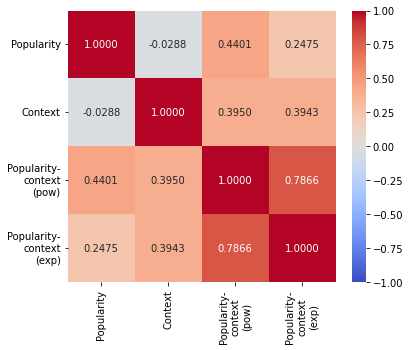

In [128]:
df_corr = patent_pair[["popularity", "similarity", "regression_pow", "regression_exp"]].corr()

plt.rcParams["figure.figsize"] = (6, 5)
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".4f", vmin=-1, vmax=1)
plt.xticks([0.5 + i for i in range(4)], ["Popularity", "Context", "Popularity-\ncontext\n(pow)", "Popularity-\ncontext\n(exp)"])
plt.yticks([0.5 + i for i in range(4)], ["Popularity", "Context", "Popularity-\ncontext\n(pow)", "Popularity-\ncontext\n(exp)"])
plt.show()

Parameters:
	Year window:	4
	Number of it.:	50


Year 2000:   0%|          | 0/5 [00:00<?, ?it/s]

Col 1:   0%|          | 0/51 [00:00<?, ?it/s]

ROC AUC (popularity): 0.2185
Opt. th (popularity): 0.17067768


Col 2:   0%|          | 0/51 [00:00<?, ?it/s]

ROC AUC (z_score): 0.7462
Opt. th (z_score): -0.77868025


Col 3:   0%|          | 0/51 [00:00<?, ?it/s]

ROC AUC (similarity): 0.8003
Opt. th (similarity): 0.33017534


Col 4:   0%|          | 0/51 [00:00<?, ?it/s]

ROC AUC (regression_pow): 0.5065
Opt. th (regression_pow): 0.00024612


Col 5:   0%|          | 0/51 [00:00<?, ?it/s]

ROC AUC (regression_exp): 0.6023
Opt. th (regression_exp): 0.00029207


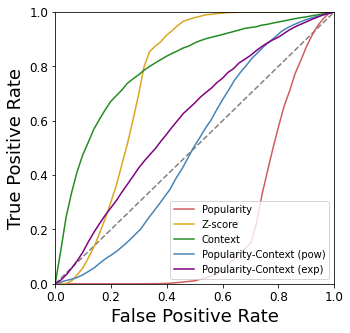

In [132]:
# patent_pair_unique = patent_pair[patent_pair.pair_count > 0][["w1", "w2", "year"]].groupby(["w1", "w2"]).min().rename(columns={"year": "innovation_year"})

target_cols = ["popularity", "z_score", "similarity", "regression_pow", "regression_exp"]
target_labels = ["Popularity", "Z-score", "Context", "Popularity-Context (pow)", "Popularity-Context (exp)"]
# cmaps = ["indianred", "steelblue"]
cmaps = ["indianred", "goldenrod", "forestgreen", "steelblue", "purple"]
target_year = 2000
year_window = 4
iterbin = 50

print("Parameters:")
print("\tYear window:\t{}".format(year_window))
print("\tNumber of it.:\t{}".format(iterbin))

auc_data = {col: [] for col in ["year"] + target_cols}

plt.rcParams["figure.figsize"] = (5, 5)
plt.plot([0, 1], [0, 1], c="gray", linestyle="--")

df_pair = pd.merge(patent_pair, patent_pair_unique[["w1", "w2", "innovation_year", "z_th"]], on=["w1", "w2"], how="left").fillna({"innovation_year": 3000})
df_pair = df_pair[df_pair.year < df_pair.innovation_year]
df_pair = df_pair[(df_pair.year >= target_year - year_window - 1) & (df_pair.year < target_year)]
df_pair["predict_year"] = df_pair.year + 1

for n, target_col in tqdm(enumerate(target_cols), desc="Year {}".format(target_year), total=len(target_cols)):

    col_sorted = df_pair.sort_values(by=target_col).reset_index(drop=True)[target_col]

    model_param = {col:[] for col in ["th", "T", "P", "TP", "FP", "TN", "FN", "TPR", "FPR", "best_dist", "worst_dist"]}

    for i in tqdm(range(iterbin+1), desc="Col {}".format(n+1)):
        if i < iterbin:
            th = col_sorted[int(i*len(df_pair)/iterbin)]
        else:
            th = col_sorted[len(df_pair)-1]
            

        if not np.isnan(th):

            df_pair["TP"] = (df_pair.innovation_year == df_pair.predict_year) & (df_pair.z_th) & (df_pair[target_col]>=th)
            df_pair["FP"] = ~((df_pair.innovation_year == df_pair.predict_year) & (df_pair.z_th)) & (df_pair[target_col]>=th)
            df_pair["FN"] = (df_pair.innovation_year == df_pair.predict_year) & (df_pair.z_th) & (df_pair[target_col]<th)
            df_pair["TN"] = ~((df_pair.innovation_year == df_pair.predict_year) & (df_pair.z_th)) & (df_pair[target_col]<th)

            TP = sum(df_pair.TP)
            FP = sum(df_pair.FP)
            TN = sum(df_pair.TN)
            FN = sum(df_pair.FN)

            TPR = TP/(TP+FN)
            FPR = FP/(FP+TN)

            model_param["th"].append(th)

            model_param["T"].append(TP + FN)
            model_param["P"].append(TP + FP)

            model_param["TP"].append(TP)
            model_param["FP"].append(FP)
            model_param["TN"].append(TN)
            model_param["FN"].append(FN)

            model_param["TPR"].append(TPR)
            model_param["FPR"].append(FPR)

            model_param["best_dist"].append((1-TPR)**2 + FPR**2)
            model_param["worst_dist"].append(((FPR-TPR)**2)/2)

    df_roc = pd.DataFrame(model_param)

    x = [abs(x1-x2) for x1, x2 in zip(df_roc.FPR[:-1], df_roc.FPR[1:])]
    y = [(y1+y2)/2 for y1, y2 in zip(df_roc.TPR[:-1], df_roc.TPR[1:])]

    auc = sum([a*b for a, b in zip(x, y)])
#         ax[int(n/2)][n%2].text(0.7, 0.07, "AUC={0:.4f}".format(auc), fontsize=12)

    plt.plot(df_roc.FPR.values, df_roc.TPR.values, label=target_labels[n], color=cmaps[n])
    
    print("ROC AUC ({0}): {1:.4f}".format(target_col, auc))
    print("Opt. th ({0}): {1:.8f}".format(target_col, df_roc.sort_values(by="best_dist").th.values[0]))

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
        
plt.show()

In [130]:
df_pair

,w1,w2,similarity,similarity_std,year,pair_count_x,k1,k2,family_count,popularity,...,regression_exp,innovation_year,pair_count_y,z_score_y,z_th,predict_year,TP,FP,FN,TN
0,A01B,A01C,0.817786,0.021898,1996,193,6062,6614,2629383,15.248470,...,0.033189,3000.0,NaN,NaN,NaN,1997,False,False,False,True
1,A01B,A01D,0.817335,0.022531,1996,117,6062,6712,2629383,15.474407,...,0.033333,3000.0,NaN,NaN,NaN,1997,False,False,False,True
2,A01B,A01F,0.512621,0.031572,1996,4,6062,3419,2629383,7.882449,...,0.002495,3000.0,NaN,NaN,NaN,1997,False,False,False,True
3,A01B,A01G,0.608446,0.047579,1996,50,6062,12257,2629383,28.258315,...,0.009919,3000.0,NaN,NaN,NaN,1997,False,False,False,True
4,A01B,A01H,0.527471,0.034622,1996,0,6062,4823,2629383,11.119349,...,0.003203,1998.0,1.0,-3.486505,False,1997,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807080,H05F,H05H,0.345870,0.042607,1999,1,913,4144,2926705,1.292741,...,0.000379,3000.0,NaN,NaN,NaN,2000,False,False,False,True
807081,H05F,H05K,0.492834,0.034861,1999,12,913,50412,2926705,15.726271,...,0.011638,3000.0,NaN,NaN,NaN,2000,False,False,False,True
807082,H05G,H05H,0.578974,0.034311,1999,14,925,4144,2926705,1.309732,...,0.002198,3000.0,NaN,NaN,NaN,2000,False,False,False,True
807083,H05G,H05K,0.299656,0.026150,1999,0,925,50412,2926705,15.932969,...,0.002719,3000.0,NaN,NaN,NaN,2000,False,False,False,True
